<div style="margin-bottom: 32px;">
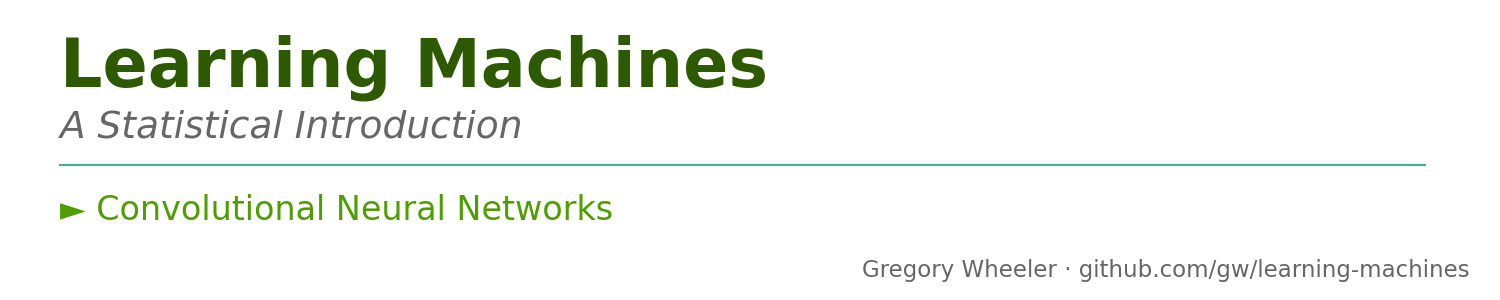
</div>


# Convolutional Neural Networks

Convolutional networks exploit spatial structure in images by applying learned filters that slide across the input. This notebook makes the convolution operation concrete: we visualize what filters detect, see feature maps emerge, and build a simple CNN for image classification.

**What computation adds**: Diagrams show one filter on one patch; here we watch filters slide across entire images, see how stacking layers builds hierarchical representations, and peek at what a trained network learns to see.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import sys
from pathlib import Path

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Add the notebook directory to path for imports
sys.path.insert(0, str(Path.cwd()))

# Import our custom theme
import mlone_theme as mt

# Apply the style and set notebook mode
plt.style.use('mlone_style.mplstyle')
mt.set_notebook_mode()

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 1. The Convolution Operation

A 2D convolution slides a small **filter** (or kernel) across an image, computing the dot product at each position. The result is a **feature map** that highlights where the filter pattern appears.

Let's implement convolution from scratch to see exactly what happens.

In [2]:
def conv2d_manual(image, kernel):
    """
    Apply 2D convolution (no padding, stride=1).
    
    image: 2D array of shape (H, W)
    kernel: 2D array of shape (kH, kW)
    
    Returns: 2D array of shape (H - kH + 1, W - kW + 1)
    """
    H, W = image.shape
    kH, kW = kernel.shape
    
    out_H = H - kH + 1
    out_W = W - kW + 1
    
    output = np.zeros((out_H, out_W))
    
    for i in range(out_H):
        for j in range(out_W):
            # Extract patch and compute dot product
            patch = image[i:i+kH, j:j+kW]
            output[i, j] = np.sum(patch * kernel)
    
    return output

In [3]:
# Create a simple test image with edges
image = np.zeros((10, 10))
image[2:8, 2:8] = 1  # White square on black background

# Common edge-detection filters
vertical_edge = np.array([[-1, 0, 1],
                          [-1, 0, 1],
                          [-1, 0, 1]])

horizontal_edge = np.array([[-1, -1, -1],
                            [ 0,  0,  0],
                            [ 1,  1,  1]])

# Apply convolutions
vert_response = conv2d_manual(image, vertical_edge)
horiz_response = conv2d_manual(image, horizontal_edge)

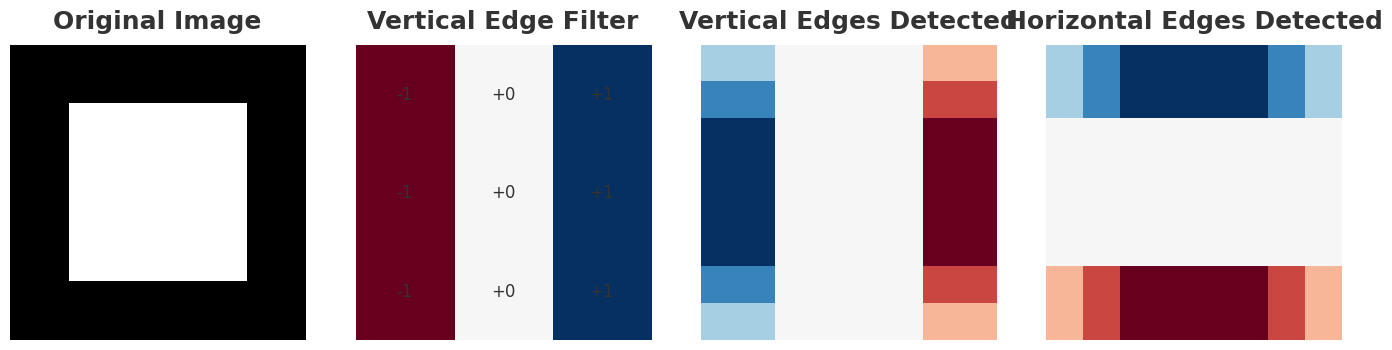

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))

# Original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image', fontweight='bold')
axes[0].axis('off')

# Vertical edge filter
axes[1].imshow(vertical_edge, cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_title('Vertical Edge Filter', fontweight='bold')
axes[1].axis('off')
for i in range(3):
    for j in range(3):
        axes[1].text(j, i, f'{vertical_edge[i,j]:+.0f}', ha='center', va='center', fontsize=12)

# Vertical edge response
im = axes[2].imshow(vert_response, cmap='RdBu')
axes[2].set_title('Vertical Edges Detected', fontweight='bold')
axes[2].axis('off')

# Horizontal edge response
axes[3].imshow(horiz_response, cmap='RdBu')
axes[3].set_title('Horizontal Edges Detected', fontweight='bold')
axes[3].axis('off')

plt.tight_layout()
plt.show()

The vertical edge filter responds positively to left edges (dark→light) and negatively to right edges (light→dark). The horizontal filter does the same for top/bottom edges.

## 2. Visualizing the Sliding Window

Let's animate how the filter slides across the image.

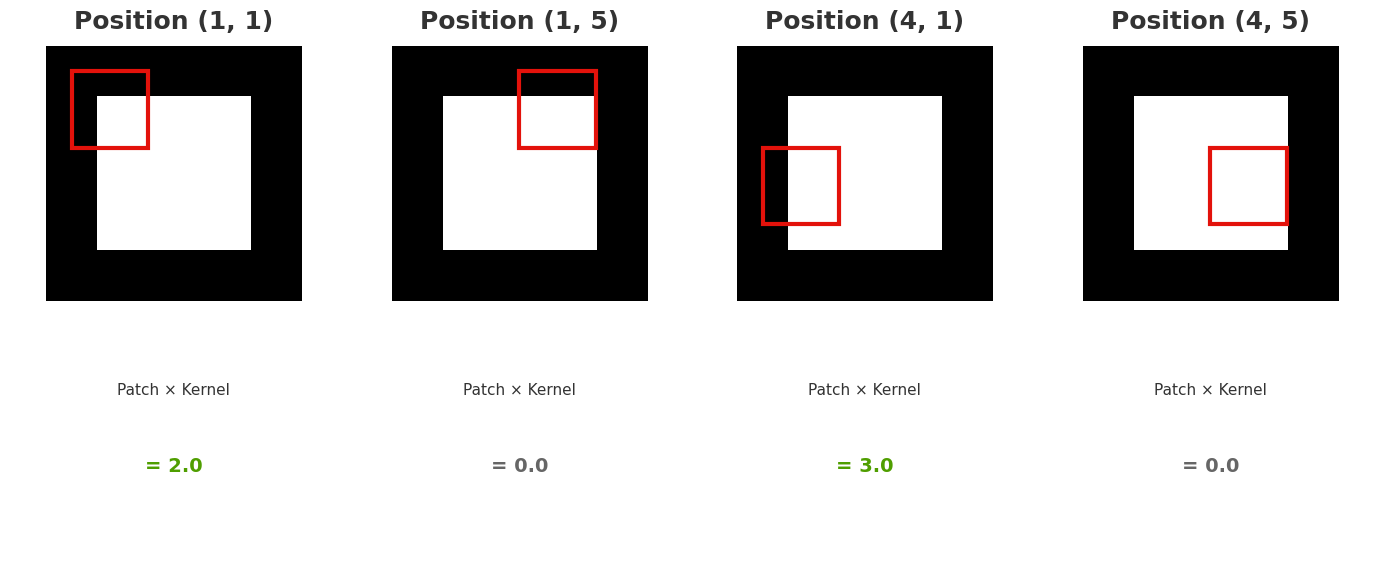

In [5]:
def visualize_convolution_steps(image, kernel, positions=None):
    """
    Show convolution at specific filter positions.
    """
    H, W = image.shape
    kH, kW = kernel.shape
    
    if positions is None:
        positions = [(0, 0), (0, 4), (3, 3), (5, 5)]
    
    fig, axes = plt.subplots(2, len(positions), figsize=(3.5*len(positions), 6))
    
    for col, (i, j) in enumerate(positions):
        # Top row: image with filter overlay
        ax = axes[0, col]
        ax.imshow(image, cmap='gray')
        
        # Highlight current patch
        rect = Rectangle((j-0.5, i-0.5), kW, kH, 
                         linewidth=3, edgecolor=mt.RED, facecolor='none')
        ax.add_patch(rect)
        
        ax.set_title(f'Position ({i}, {j})', fontweight='bold')
        ax.axis('off')
        
        # Bottom row: patch, kernel, and result
        ax = axes[1, col]
        patch = image[i:i+kH, j:j+kW]
        result = np.sum(patch * kernel)
        
        # Show computation
        ax.text(0.5, 0.7, f'Patch × Kernel', ha='center', transform=ax.transAxes, fontsize=11)
        ax.text(0.5, 0.4, f'= {result:.1f}', ha='center', transform=ax.transAxes, 
               fontsize=14, fontweight='bold', color=mt.GREEN if result > 0 else mt.RED if result < 0 else mt.GRAY)
        ax.axis('off')
    
    plt.tight_layout()
    return fig

fig = visualize_convolution_steps(image, vertical_edge, [(1, 1), (1, 5), (4, 1), (4, 5)])
plt.show()

## 3. Convolution in PyTorch

In practice, we use optimized implementations. PyTorch's `nn.Conv2d` handles batches, multiple channels, and runs on GPU.

Two key parameters control the convolution:
- **Stride**: How many pixels to move the filter at each step. Stride 1 (default) moves one pixel at a time; stride 2 skips every other position, halving output size.
- **Padding**: Zeros added around the image border. With `padding=1` and a 3×3 filter, the output has the same size as the input.

In [6]:
# Convert our image to PyTorch format: (batch, channels, height, width)
image_torch = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
print(f'Image shape: {image_torch.shape}')  # (1, 1, 10, 10)

# Create a Conv2d layer and set our filter weights
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, bias=False, padding=0)
conv.weight.data = torch.tensor(vertical_edge, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Apply convolution
with torch.no_grad():
    output_torch = conv(image_torch)

print(f'Output shape: {output_torch.shape}')  # (1, 1, 8, 8)

# Verify it matches our manual implementation
print(f'Max difference from manual: {np.max(np.abs(output_torch.numpy()[0,0] - vert_response)):.6f}')

Image shape: torch.Size([1, 1, 10, 10])
Output shape: torch.Size([1, 1, 8, 8])
Max difference from manual: 0.000000


## 4. Pooling: Downsampling Feature Maps

**Pooling** reduces the spatial size of feature maps, making the network:
- More computationally efficient
- Less sensitive to exact positions (translation invariance)

**Max pooling** takes the maximum value in each region; **average pooling** takes the mean.

In [7]:
def max_pool_manual(image, pool_size=2):
    """Apply max pooling with non-overlapping windows."""
    H, W = image.shape
    out_H = H // pool_size
    out_W = W // pool_size
    
    output = np.zeros((out_H, out_W))
    
    for i in range(out_H):
        for j in range(out_W):
            patch = image[i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size]
            output[i, j] = np.max(patch)
    
    return output

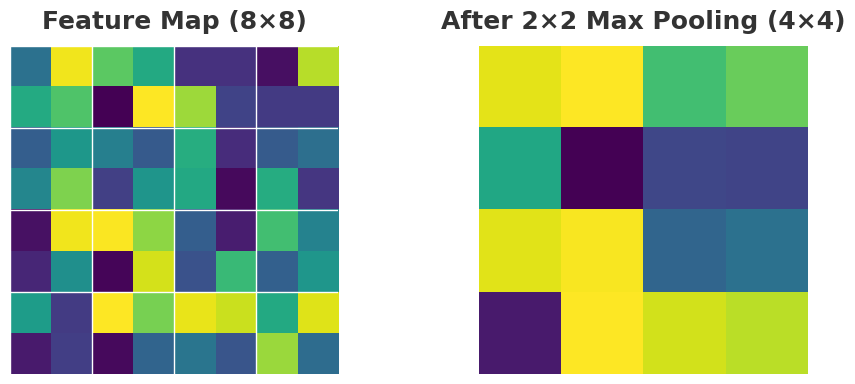

Size reduced from (8, 8) to (4, 4)
Parameters preserved: the max from each 2×2 region


In [8]:
# Create a feature map to pool
np.random.seed(42)
feature_map = np.random.rand(8, 8)

# Apply 2x2 max pooling
pooled = max_pool_manual(feature_map, pool_size=2)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Before pooling
ax = axes[0]
im = ax.imshow(feature_map, cmap='viridis')
ax.set_title(f'Feature Map (8×8)', fontweight='bold')
ax.axis('off')

# Draw 2x2 grid
for i in range(0, 8, 2):
    ax.axhline(y=i-0.5, color='white', linewidth=1)
    ax.axvline(x=i-0.5, color='white', linewidth=1)

# After pooling
ax = axes[1]
ax.imshow(pooled, cmap='viridis')
ax.set_title(f'After 2×2 Max Pooling (4×4)', fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

print(f'Size reduced from {feature_map.shape} to {pooled.shape}')
print(f'Parameters preserved: the max from each 2×2 region')

## 5. A Simple CNN Architecture

A typical CNN stacks:
1. **Convolutional layers**: Learn filters that detect features
2. **Activation functions**: Add nonlinearity (ReLU)
3. **Pooling layers**: Reduce spatial size
4. **Fully connected layers**: Combine features for classification

In [9]:
class SimpleCNN(nn.Module):
    """
    A simple CNN for MNIST digit classification.
    
    Architecture:
        Conv(1->16, 3x3) -> ReLU -> MaxPool(2x2)
        Conv(16->32, 3x3) -> ReLU -> MaxPool(2x2)
        Flatten -> FC(32*5*5 -> 64) -> ReLU -> FC(64 -> 10)
    """
    
    def __init__(self):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        # After two 2x2 poolings: 28 -> 14 -> 7
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):
        # Conv block 1: 28x28 -> 14x14
        x = self.pool(F.relu(self.conv1(x)))
        
        # Conv block 2: 14x14 -> 7x7
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten and classify
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

model = SimpleCNN()
print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

Total parameters: 105,866


## 6. Training on MNIST

Let's train our CNN on the MNIST handwritten digit dataset.

In [10]:
# Note: First run will download the MNIST dataset (~11MB)

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Use smaller subset for faster training in this demo
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Training samples: 60000
Test samples: 10000


In [ ]:
# Visualize some training samples
fig, axes = plt.subplots(2, 8, figsize=(12, 3.5), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    image, label = train_dataset[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'{label}', fontsize=12)
    ax.axis('off')

fig.suptitle('MNIST Training Samples', fontweight='bold')
plt.show()

In [12]:
def train_epoch(model, loader, optimizer, criterion):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += len(data)
    
    return total_loss / total, correct / total


def evaluate(model, loader, criterion):
    """Evaluate the model."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item() * len(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += len(data)
    
    return total_loss / total, correct / total

In [13]:
# Train the model
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

n_epochs = 5
train_losses, test_losses = [], []
train_accs, test_accs = [], []

print('Training CNN on MNIST...')
print('-' * 50)

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch+1}/{n_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.1%} | '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.1%}')

Training CNN on MNIST...
--------------------------------------------------
Epoch 1/5: Train Loss: 0.1836, Train Acc: 94.4% | Test Loss: 0.0721, Test Acc: 97.4%
Epoch 2/5: Train Loss: 0.0552, Train Acc: 98.3% | Test Loss: 0.0432, Test Acc: 98.6%
Epoch 3/5: Train Loss: 0.0396, Train Acc: 98.7% | Test Loss: 0.0374, Test Acc: 98.7%
Epoch 4/5: Train Loss: 0.0300, Train Acc: 99.1% | Test Loss: 0.0404, Test Acc: 98.7%
Epoch 5/5: Train Loss: 0.0254, Train Acc: 99.2% | Test Loss: 0.0471, Test Acc: 98.4%


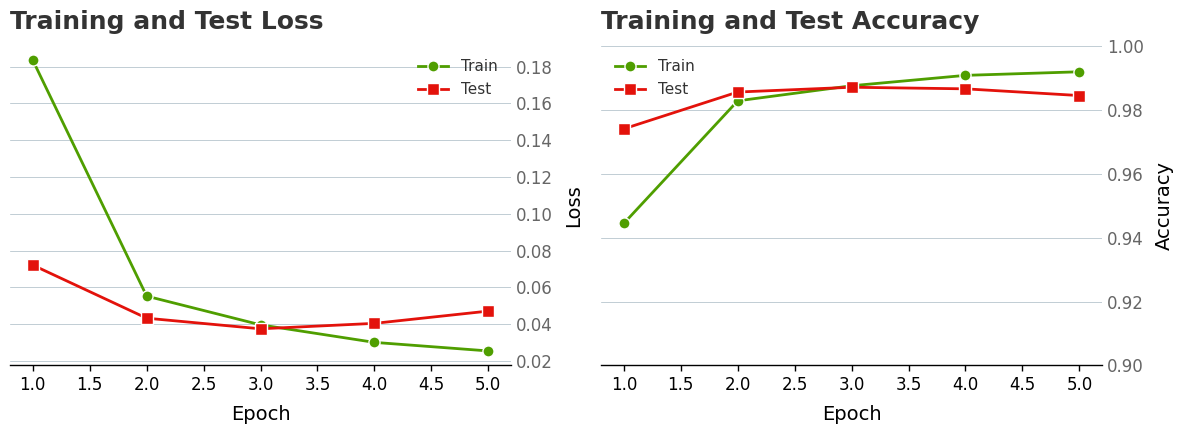

In [14]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Loss
ax = axes[0]
ax.plot(range(1, n_epochs+1), train_losses, 'o-', c=mt.GREEN, linewidth=2, markersize=8, label='Train')
ax.plot(range(1, n_epochs+1), test_losses, 's-', c=mt.RED, linewidth=2, markersize=8, label='Test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Test Loss', fontweight='bold', loc='left')
ax.legend()
mt.apply_economist_style(ax)

# Accuracy
ax = axes[1]
ax.plot(range(1, n_epochs+1), train_accs, 'o-', c=mt.GREEN, linewidth=2, markersize=8, label='Train')
ax.plot(range(1, n_epochs+1), test_accs, 's-', c=mt.RED, linewidth=2, markersize=8, label='Test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Test Accuracy', fontweight='bold', loc='left')
ax.legend()
ax.set_ylim(0.9, 1.0)
mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

## 7. Visualizing Learned Filters

What patterns has the network learned to detect? Let's visualize the first-layer filters.

In [ ]:
# Extract first-layer filters
filters = model.conv1.weight.data.cpu().numpy()
print(f'First layer filters shape: {filters.shape}')  # (16, 1, 3, 3)

fig, axes = plt.subplots(2, 8, figsize=(14, 4), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    # Each filter: (1, 3, 3) -> (3, 3)
    filt = filters[i, 0]
    ax.imshow(filt, cmap='RdBu', vmin=-0.5, vmax=0.5)
    ax.set_title(f'Filter {i+1}', fontsize=10)
    ax.axis('off')

fig.suptitle('Learned First-Layer Filters (3×3)', fontweight='bold')
plt.show()

Many filters look like edge detectors at different orientations—similar to what we designed by hand, but learned from data.

## 8. Visualizing Feature Maps

What does the network "see" at each layer? Let's pass an image through and visualize the activations.

In [16]:
def get_activations(model, image):
    """
    Get activations at each conv layer.
    """
    activations = {}
    
    x = image.unsqueeze(0).to(device)  # Add batch dimension
    
    # After conv1
    x = model.conv1(x)
    activations['conv1'] = x.detach().cpu()
    x = F.relu(x)
    activations['conv1_relu'] = x.detach().cpu()
    x = model.pool(x)
    
    # After conv2
    x = model.conv2(x)
    activations['conv2'] = x.detach().cpu()
    x = F.relu(x)
    activations['conv2_relu'] = x.detach().cpu()
    
    return activations

# Get a test image
test_image, test_label = test_dataset[0]
activations = get_activations(model, test_image)

In [ ]:
fig, axes = plt.subplots(3, 9, figsize=(14, 5), constrained_layout=True)

# Row 1: Original image and first 8 conv1 feature maps
axes[0, 0].imshow(test_image.squeeze(), cmap='gray')
axes[0, 0].set_title(f'Input ({test_label})', fontweight='bold')
axes[0, 0].axis('off')

conv1_acts = activations['conv1_relu'][0]  # (16, 28, 28)
for i in range(8):
    axes[0, i+1].imshow(conv1_acts[i], cmap='viridis')
    axes[0, i+1].axis('off')
    if i == 0:
        axes[0, i+1].set_title('Conv1 Feature Maps', fontweight='bold')

# Row 2: More conv1 feature maps
axes[1, 0].axis('off')
for i in range(8):
    axes[1, i+1].imshow(conv1_acts[i+8] if i+8 < 16 else np.zeros((28,28)), cmap='viridis')
    axes[1, i+1].axis('off')

# Row 3: Conv2 feature maps (8 of 32)
conv2_acts = activations['conv2_relu'][0]  # (32, 14, 14)
axes[2, 0].axis('off')
for i in range(8):
    axes[2, i+1].imshow(conv2_acts[i], cmap='viridis')
    axes[2, i+1].axis('off')
    if i == 0:
        axes[2, i+1].set_title('Conv2 Feature Maps', fontweight='bold')

plt.show()

**Observations:**
- **Conv1** feature maps detect low-level features (edges, strokes)
- **Conv2** feature maps are smaller (after pooling) and detect higher-level patterns
- Different filters activate for different parts of the digit

## 9. Looking at Predictions

Let's see some correct and incorrect predictions.

In [18]:
# Get predictions on test set
model.eval()
all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data)
        pred = output.argmax(dim=1).cpu().numpy()
        all_preds.extend(pred)
        all_labels.extend(target.numpy())
        all_images.extend(data.cpu())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Find some misclassified examples
mistakes = np.where(all_preds != all_labels)[0]
print(f'Misclassified: {len(mistakes)} out of {len(all_labels)} ({len(mistakes)/len(all_labels):.1%})')

Misclassified: 156 out of 10000 (1.6%)


In [ ]:
# Show some mistakes
fig, axes = plt.subplots(2, 6, figsize=(14, 5), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i < len(mistakes):
        idx = mistakes[i]
        img = all_images[idx].squeeze().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {all_labels[idx]}\nPred: {all_preds[idx]}', 
                    color=mt.RED, fontweight='bold', fontsize=10)
    ax.axis('off')

fig.suptitle('Misclassified Examples', fontweight='bold')
plt.show()

Many mistakes are on ambiguous or poorly written digits—cases where even humans might struggle.

---

## Summary

**Convolution:**
- Slides learned filters across images
- Produces feature maps that highlight where patterns appear
- Shares weights across positions (translation equivariance)

**Pooling:**
- Reduces spatial size
- Provides some translation invariance
- Max pooling keeps strongest activations

**CNN architecture:**
- Stack conv → activation → pool blocks
- Early layers learn edges; later layers learn shapes
- Flatten and use fully connected layers for final classification

**Key insight:** The network learns what features to detect (the filters) directly from data, rather than requiring hand-designed feature extractors.

## Exploration

Try modifying:
- **Architecture**: Add more conv layers or change filter sizes
- **Dropout**: Add `nn.Dropout` to reduce overfitting
- **Different dataset**: Try Fashion-MNIST (same size, harder classes)
- **Visualizations**: Look at which inputs maximally activate specific neurons